The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install -U mxnet-cu101==1.7.0
!pip install d2l==0.16.2


     |███████████████████████████████▌| 834.1MB 1.2MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x55d2106ec000 @  0x7f947e4a1615 0x55d1d654106c 0x55d1d6620eba 0x55d1d6543e8d 0x55d1d663599d 0x55d1d65b7fe9 0x55d1d65b2b0e 0x55d1d654577a 0x55d1d65b7e50 0x55d1d65b2b0e 0x55d1d654577a 0x55d1d65b486a 0x55d1d66367c6 0x55d1d65b3ee2 0x55d1d66367c6 0x55d1d65b3ee2 0x55d1d66367c6 0x55d1d65b3ee2 0x55d1d66367c6 0x55d1d65b3ee2 0x55d1d654569a 0x55d1d65b3c9e 0x55d1d65b2e0d 0x55d1d654577a 0x55d1d65b3a45 0x55d1d654569a 0x55d1d65b3a45 0x55d1d65b2b0e 0x55d1d654577a 0x55d1d65b486a 0x55d1d65b2b0e
     |████████████████████████████████| 846.0MB 22kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 81kB 5.4MB/s 


# The Object Detection Dataset

There are no small datasets, like MNIST or Fashion-MNIST, in the object detection field. In order to quickly test models, we are going to assemble a small dataset. First, we generate 1000 banana images of different angles and sizes using free bananas from our office. Then, we collect a series of background images and place a banana image at a random position on each image.


## Downloading the Dataset

The banana detection dataset with all the images and csv label files can be
downloaded directly from the Internet.


In [2]:
%matplotlib inline
import os
import pandas as pd
from mxnet import gluon, image, np, npx
from d2l import mxnet as d2l

npx.set_np()

#@save
d2l.DATA_HUB['banana-detection'] = (d2l.DATA_URL + 'banana-detection.zip',
                           '5de26c8fce5ccdea9f91267273464dc968d20d72')

## Reading the Dataset

We are going to read the object detection dataset in the `read_data_bananas`
function. The dataset includes a csv file for target class labels and
ground truth bounding box coordinates in the `corner` format.
We define `BananasDataset` to create the `Dataset` instance and finally define
the `load_data_bananas` function to return the dataloaders.
There is no need to read the test dataset in random order.


In [3]:
#@save
def read_data_bananas(is_train=True):
    """Read the bananas dataset images and labels."""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir,
                             'bananas_train' if is_train else 'bananas_val',
                             'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(
            image.imread(
                os.path.join(data_dir,
                             'bananas_train' if is_train else 'bananas_val',
                             'images', f'{img_name}')))
        # Since all images have same object class i.e. category '0',
        # the `label` column corresponds to the only object i.e. banana
        # The target is as follows : (`label`, `xmin`, `ymin`, `xmax`, `ymax`)
        targets.append(list(target))
    return images, np.expand_dims(np.array(targets), 1) / 256

#@save
class BananasDataset(gluon.data.Dataset):
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (
            f' training examples' if is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].astype('float32').transpose(2, 0, 1),
                self.labels[idx])

    def __len__(self):
        return len(self.features)

#@save
def load_data_bananas(batch_size):
    """Load the bananas dataset."""
    train_iter = gluon.data.DataLoader(BananasDataset(is_train=True),
                                       batch_size, shuffle=True)
    val_iter = gluon.data.DataLoader(BananasDataset(is_train=False),
                                     batch_size)
    return (train_iter, val_iter)

Below, we read a minibatch and print the shape of the image and label. The shape of the image is the same as in the previous experiment (batch size, number of channels, height, width). The shape of the label is (batch size, $m$, 5), where $m$ is equal to the maximum number of bounding boxes contained in a single image in the dataset. Although computation for the minibatch is very efficient, it requires each image to contain the same number of bounding boxes so that they can be placed in the same batch. Since each image may have a different number of bounding boxes, we can add illegal bounding boxes to images that have less than $m$ bounding boxes until each image contains $m$ bounding boxes. Thus, we can read a minibatch of images each time. The label of each bounding box in the image is represented by a tensor of length 5. The first element in the tensor is the category of the object contained in the bounding box. When the value is -1, the bounding box is an illegal bounding box for filling purpose. The remaining four elements of the array represent the $x, y$ axis coordinates of the upper-left corner of the bounding box and the $x, y$ axis coordinates of the lower-right corner of the bounding box (the value range is between 0 and 1). The banana dataset here has only one bounding box per image, so $m=1$.


In [4]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


((32, 3, 256, 256), (32, 1, 5))

## Demonstration

We have ten images with bounding boxes on them. We can see that the angle, size, and position of banana are different in each image. Of course, this is a simple artificial dataset. In actual practice, the data are usually much more complicated.


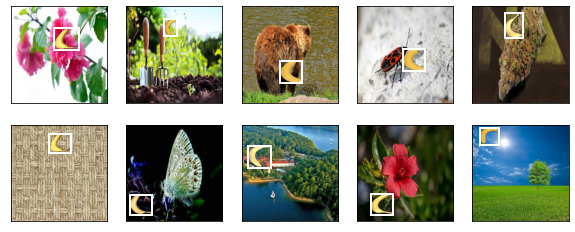

In [5]:
imgs = (batch[0][0:10].transpose(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

## Summary

* The banana detection dataset we synthesized can be used to test object detection models.
* The data reading for object detection is similar to that for image classification. However, after we introduce bounding boxes, the label shape and image augmentation (e.g., random cropping) are changed.


## Exercises

1. Referring to the MXNet documentation, what are the parameters for the constructors of the `image.ImageDetIter` and `image.CreateDetAugmenter` classes? What is their significance?


[Discussions](https://discuss.d2l.ai/t/372)


In [6]:
!pip install gluoncv

     |████████████████████████████████| 1.1MB 9.2MB/s 
     |████████████████████████████████| 317kB 31.7MB/s 
     |████████████████████████████████| 122kB 35.0MB/s 
     |████████████████████████████████| 14.1MB 248kB/s 
     |████████████████████████████████| 215kB 57.6MB/s 
     |████████████████████████████████| 686kB 46.2MB/s 
     |████████████████████████████████| 952kB 51.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 133kB 58.2MB/s 
     |████████████████████████████████| 3.2MB 51.9MB/s 
     |████████████████████████████████| 71kB 11.7MB/s 
     |████████████████████████████████| 962kB 50.1MB/s 
     |████████████████████████████████| 7.4MB 47.3MB/s 
     |████████████████████████████████| 81kB 14.3MB/s 
  Created wheel for ConfigSpace: filename=ConfigSpace-0.4.18-cp37-cp37m-linux_x86_64.whl size=2879720 sha256=cece5429f0300158ca56a66118e748e47422bf0c

In [1]:
from __future__ import division

import argparse, time, logging, random, math

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, TrainingHistory
from gluoncv.data import transforms as gcv_transforms

In [2]:
# number of GPUs to use
num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]

# Get the model CIFAR_ResNet20_v1, with 10 output classes, without pre-trained weights
net = get_model('cifar_resnet20_v1', classes=10)
net.initialize(mx.init.Xavier(), ctx = ctx)

In [3]:
transform_train = transforms.Compose([
    # Randomly crop an area and resize it to be 32x32, then pad it to be 40x40
    gcv_transforms.RandomCrop(32, pad=4),
    # Randomly flip the image horizontally
    transforms.RandomFlipLeftRight(),
    # Transpose the image from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    transforms.ToTensor(),
    # Normalize the image with mean and standard deviation calculated across all images
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

In [4]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

In [5]:
# Batch Size for Each GPU
per_device_batch_size = 128
# Number of data loader workers
num_workers = 8
# Calculate effective total batch size
batch_size = per_device_batch_size * num_gpus

# Set train=True for training data
# Set shuffle=True to shuffle the training data
train_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR10(train=True).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=num_workers)

# Set train=False for validation data
val_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR10(train=False).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [6]:
# Learning rate decay factor
lr_decay = 0.1
# Epochs where learning rate decays
lr_decay_epoch = [80, 160, np.inf]

# Nesterov accelerated gradient descent
optimizer = 'nag'
# Set parameters
optimizer_params = {'learning_rate': 0.1, 'wd': 0.0001, 'momentum': 0.9}

# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

In [7]:
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

In [8]:
train_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-error', 'validation-error'])

In [9]:
def test(ctx, val_data):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)
    return metric.get()

[Epoch 0] train=0.447917 val=0.534400 loss=74950.120636 time: 41.402249
[Epoch 1] train=0.649058 val=0.662600 loss=49336.800026 time: 41.513529
[Epoch 2] train=0.719892 val=0.683400 loss=39836.233948 time: 41.417973


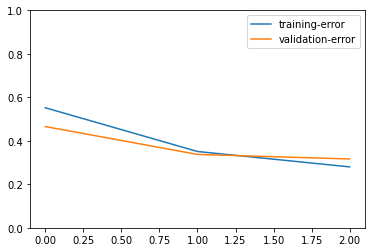

In [10]:
epochs = 3
lr_decay_count = 0

for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Learning rate decay
    if epoch == lr_decay_epoch[lr_decay_count]:
        trainer.set_learning_rate(trainer.learning_rate*lr_decay)
        lr_decay_count += 1

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = [net(X) for X in data]
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.sum().asscalar() for l in loss])
        train_metric.update(label, output)

    name, acc = train_metric.get()
    # Evaluate on Validation data
    name, val_acc = test(ctx, val_data)

    # Update history and print metrics
    train_history.update([1-acc, 1-val_acc])
    print('[Epoch %d] train=%f val=%f loss=%f time: %f' %
        (epoch, acc, val_acc, train_loss, time.time()-tic))

# We can plot the metric scores with:

train_history.plot()

In [11]:
net.save_parameters('dive_deep_cifar10_resnet20_v2.params')

In [12]:
net.load_parameters('dive_deep_cifar10_resnet20_v2.params', ctx=ctx)